#  Прогнозирование заказов такси

<a id='head'></a>
## Оглавление
 
- [Постановка задачи](#intro)
- [Подготовка](#preparation)
    - [Вывод](#conclusion_1)
    
- [Анализ данных](#analysis)
    - [1.1 Импорт библиотек и данных](#part_1_1)
    - [1.2 Предварительный обзор данных](#part_1_2)
        - [Выводы](#conclusions_1_2)
    - [1.3 Предобработка](#part_1_3)
    - [1.4 Создание общего датасета](#part_1_4)

- [**2. Исследовательский анализ данных**](#part_2)
    - [2.1 Распределение ежемесячных платежей](#part_2_1)
    - [2.2 Статистики ежемесячных платежей](#part_2_2)
    - [2.3 Доли групп с услугами интернет и телефона](#part_2_3)

<a id='intro'></a>
## Постановка задачи [▴](#head)

В данном проекте решается задача прогнозирования количества заказов такси на следующий час. Компания «Чётенькое такси» предоставляет исторические данные о заказах такси в аэропортах. Нам нужно построить модель для предсказания спроса на услуги в течение суток чтобы привлекать больше водителей в период пиковой нагрузки.

Для построения модели нам потребуется:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.

В результате нам нужно получить модель, которая предскажет количество заказов на тестовой выборке с **RMSE не более 48**.

<a id='preparation'></a>
## Подготовка [▴](#head)

Импортируем некоторые библиотеки и методы, которые помогут нам в работе с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

Загрузим данные, предоставленные компанией «Чётенькое такси». 

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, что в данных нет пропусков. Все ячейки таблицы заполнены, данные имеют подходящий формат.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Рассортируем данные и ресемплируем по одному часу.

In [4]:
data.sort_index(inplace=True)
data = data.resample('1h').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<a id='conclusion_1'></a>
### Вывод [▴](#head)

В нашем распоряжении имеется информация о количестве заказов такси с марта по август включительно. Данные целочисленного типа, приведены к формату количества заказов в час.

<a id='analysis'></a>
## Анализ данных [▴](#head)

Рассмотрим некоторые статистические характеристики данных. Визуализируем данные и закономерности посредством графиков.

Узнаем средниее количество заказов в час за каждые сутки. Посмотрим, как выглядят графики по данным за час и усредненные по суткам на всей временной шкале, в рамках 4 недель и за одну неделю. Следует отметить, что количество заказов за час сильно колеблется. Можно указать на общую тенденцию увеличения количества заказов. На временном промежутке в 4 недели нельзя выделить какой-то закономерности, указывающей на зависимость количества заказов от дня недели. Есть некоторые колебания скользящего среднего, но они не переодичны. На врепенном отрезке в одну неделю можно заметить характерные паттерны, похожие на суточные колебания количества заказов в час.

In [5]:
data['rolling_mean'] = data.rolling(24).mean()

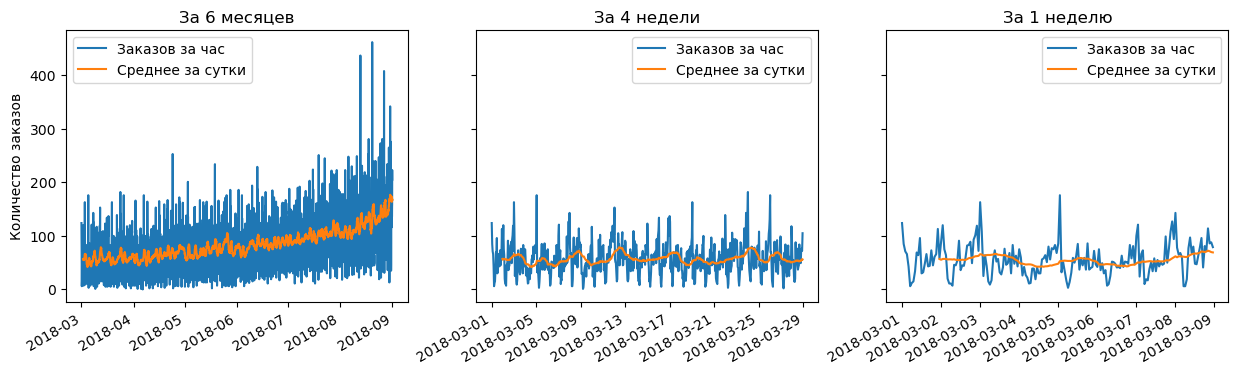

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
ax1.plot(data)
ax2.plot(data['2018-03-01':'2018-03-28'])
ax3.plot(data['2018-03-01':'2018-03-08'])
ax1.set_ylabel('Количество заказов')
ax1.set_title('За 6 месяцев')
ax2.set_title('За 4 недели')
ax3.set_title('За 1 неделю')
ax1.legend(['Заказов за час', 'Среднее за сутки'])
ax2.legend(['Заказов за час', 'Среднее за сутки'])
ax3.legend(['Заказов за час', 'Среднее за сутки'])
fig.autofmt_xdate()

Определим точнее, влияет ли день недели на количество заказов. Построим графики среднего за сутки количества заказов для каждого дня недели в отдельности. Все графики лежат рядом, нельзя выделить конкретные дни недели, когда заказов больше (может быть, вторники менее загружены у таксистов чем понедельники). Похоже, такси пользуются одинаково часто каждый день, и в выходные, и в будни.

In [7]:
data_day = pd.DataFrame(data['num_orders'].resample('1d').mean())

In [8]:
data_day['weekday'] = data_day.index.weekday

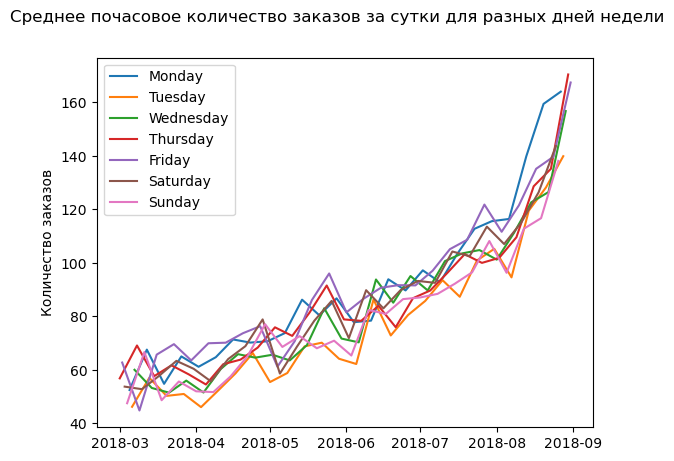

In [9]:
fig, ax = plt.subplots()
ax.plot(data_day['num_orders'][data_day['weekday']==0], label='Monday')
ax.plot(data_day['num_orders'][data_day['weekday']==1], label='Tuesday')
ax.plot(data_day['num_orders'][data_day['weekday']==2], label='Wednesday')
ax.plot(data_day['num_orders'][data_day['weekday']==3], label='Thursday')
ax.plot(data_day['num_orders'][data_day['weekday']==4], label='Friday')
ax.plot(data_day['num_orders'][data_day['weekday']==5], label='Saturday')
ax.plot(data_day['num_orders'][data_day['weekday']==6], label='Sunday')
ax.set_ylabel('Количество заказов')
fig.suptitle('Среднее почасовое количество заказов за сутки для разных дней недели')
ax.legend()

Рассмотрим подробнее, как меняется количество заказов в течении суток. На графике отобразим, сколько раз заказывали такси в полночь, в 6 утра, в полдень и в 6 вечера каждый день. На графике явно видно, что в 6 утра заказов всегда значительно меньше чем в полночь. Прослеживается зависимость количества заказов от времени суток.

In [10]:
data['hour'] = data.index.hour

Text(0.5, 0.98, 'Почасовое количество заказов для разного времени суток')

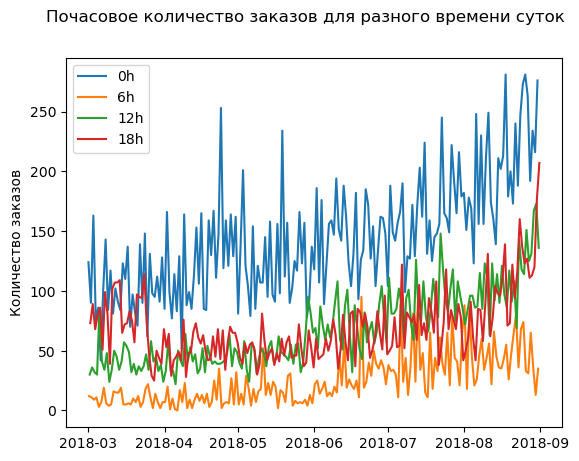

In [11]:
fig, ax = plt.subplots()
ax.plot(data['num_orders'][data['hour']==0], label='0h')
ax.plot(data['num_orders'][data['hour']==6], label='6h')
ax.plot(data['num_orders'][data['hour']==12], label='12h')
ax.plot(data['num_orders'][data['hour']==18], label='18h')
ax.set_ylabel('Количество заказов')
ax.legend()
fig.suptitle('Почасовое количество заказов для разного времени суток')

Посмотрим как ведет себя стандартное отклонение. Видим явную тенденцию к увеличению стандартного отклонения, то есть наш временной ряд нельзя назвать стационарным.

In [12]:
data['std'] = data['num_orders'].rolling(24).std()

Text(0.5, 0.98, 'Стандартное отклонение')

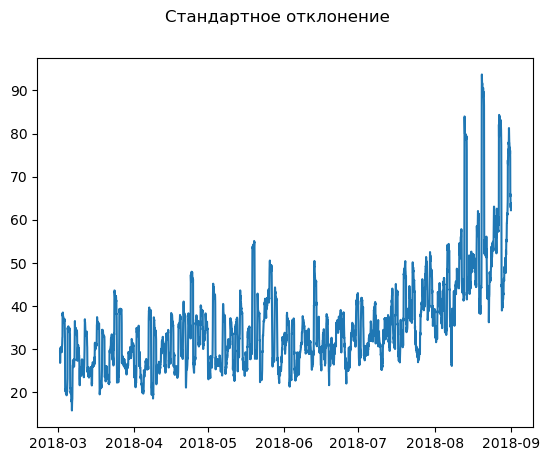

In [13]:
fig, ax = plt.subplots()
ax.plot(data['std'])
fig.suptitle('Стандартное отклонение')

В представленных выше графиках явно прослеживается тенденция к увеличению количества заказов со временем. Попробуем провести декомпозицию нашего временного ряда.<br>
Синим цветом представлены сырые данные. Красная линия показывает трендовую составляющую. График наглядно иллюстрирует  рост числа заказов со временем. Сезонная зависимость представлена широкой серой полосой. При рассмотрении в меньшем временном отрезке можно увидеть, что сезонная составляющая представляет собой суточные колебания количества заказов. Ниже представлен график сезонной составляющей для произвольной недели. Остаток (желтая линия) показывает колебания числа заказов, которые не могут быть учтены трендом и сезонной составляющей. Отметим, что размах остатка декомпозиции сравним с размахом сезонной составляющей. То есть колебания в количестве заказов сравнимы с изменением количества заказов в зависимости от времени суток.

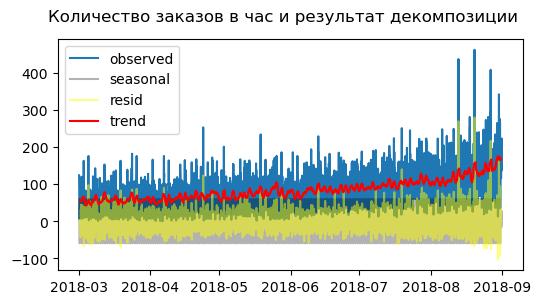

In [14]:
decomposed = seasonal_decompose(data['num_orders'].dropna())
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(decomposed.observed, label='observed')
ax.plot(decomposed.seasonal, color='black', alpha=0.3, label='seasonal')
ax.plot(decomposed.resid, color='yellow', alpha=0.5, label='resid')
ax.plot(decomposed.trend, color='red', label='trend')
ax.legend()
fig.suptitle('Количество заказов в час и результат декомпозиции')
plt.show()

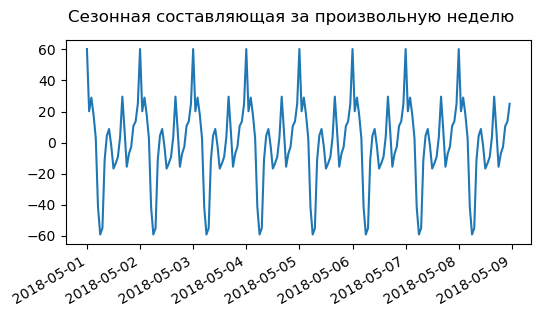

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(decomposed.seasonal['2018-05-01':'2018-05-08'])
fig.autofmt_xdate()
fig.suptitle('Сезонная составляющая за произвольную неделю')
plt.show()

### Вывод

На основании проведенного анализа можно отметить следующие особенности временного ряда:
- Количество вызовов меняется в зависимости от часа (времени суток).
- Колебания количества вызовов в течение суток значительно.
- Количество вызовов незначительно зависит от дня недели.
- Наблюдается общий тренд к увеличению количества заказов. 
- Имеющиеся данные являются нестационарным временным рядом.

## Обучение

Для обучения модели необходимо подготовить признаки. Перезагрузим данные, чтобы столбцы, с которыми мы работали в ходе анализа, не мешали в построении модели.

In [16]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1h').sum()

Мы определили, что количества заказа зависит от часа, от времени суток. Добавим соответствующий столбец. Добавим несколько столбцов с предыдущими значениями (lag): значения за несколько предыдущих часов и за тот же час в предыдущих сутках. Чтобы ориентироваться на тренд, добавим столбец со скользящим средним за 24 часа по отстающим значениям.

In [17]:
data['hour'] = data.index.hour

data['lag_1'] = data['num_orders'].shift(1)
data['lag_2'] = data['num_orders'].shift(2)
data['lag_3'] = data['num_orders'].shift(3)

data['lag_24'] = data['num_orders'].shift(24)

data['rolling_mean'] = data['lag_1'].rolling(24).mean()

Удалим строки с пустыми ячейками, которые появились вследствие сдвигов и рассчета скользящего среднего. Разделим данные на обучающую и тестовую выборки, для тестирования возьмем 10% данных. Выделим в выборках признаки и целевой признак.

In [18]:
data = data.dropna()

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [20]:
features_test = test.drop('num_orders', axis=1)
targets_test = test['num_orders']

features_train = train.drop('num_orders', axis=1)
targets_train = train['num_orders']

Обучим модель линейной регрессии и посмотрим, какую ошибку она дает при кросс-валидации. RMSE составляет около 26, это приемлемое значение.

In [21]:
model = LinearRegression()
score = cross_val_score(model, features_train, targets_train, scoring = 'neg_root_mean_squared_error', cv=TimeSeriesSplit())
-score.mean()

27.552229244999637

### Вывод

Мы подготовили данные для обучения модели - добавили некоторые признаки, разделили данные на выборки, сохранили в соответствующие модели. Обучили модель линейной регрессии, ошибка предсказания (RMSE) рассчитанная по кросс валидации составила около 26, что является хорошим показателем (требуемая ошибка по тестовым данным не более 48).

## Тестирование

Протестируем нашу модель. Предскажем значения количества заказов в час по признакам тестовой выборки, рассчитаем RMSE. Значение RMSE не превышает 48, что соответствует требованию заказчика. 

In [22]:
model = model.fit(features_train, targets_train)
predictions_test = model.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(targets_test, predictions_test, squared=False)) 

RMSE тестовой выборки:  47.18084286561371


In [23]:
targets_test = pd.DataFrame(targets_test)
targets_test['pred'] = predictions_test

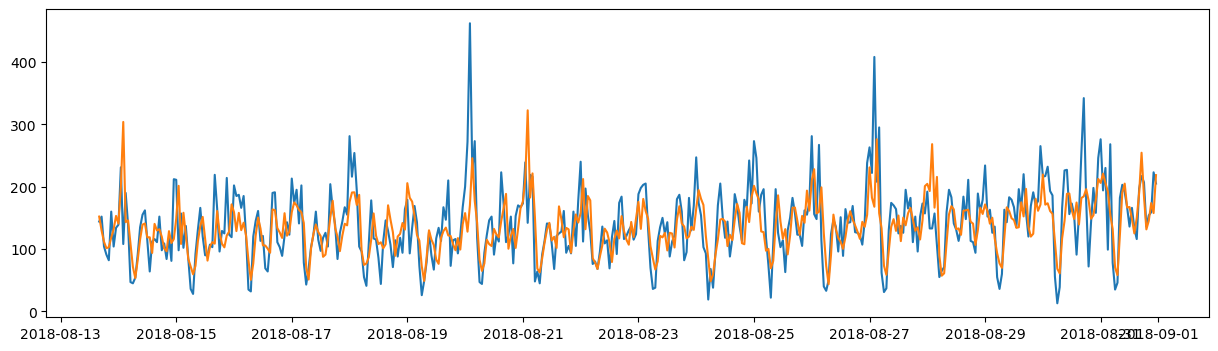

In [24]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(targets_test)

### Вывод

Модель линейной регрессии подходит для предсказания количества заказов такси в следующий час. RMSE тестовой выборки:  47